# Delays prediction

In [ ]:
# import libraries and reload data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier

# Load the dataset again
file_path = "ml_ready_airport_airline_final.csv"
df = pd.read_csv(file_path)

In [ ]:
# exploring table
df

,Unnamed: 0,year,month,carrier,carrier_name,airport,airport_name,arr_flights,arr_del15,carrier_ct,...,security_ct,late_aircraft_ct,arr_cancelled,arr_diverted,arr_delay,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay
0,96,2023,8,AA,American Airlines Inc.,ATL,"Atlanta, GA: Hartsfield-Jackson Atlanta Intern...",759.0,225.0,67.14,...,0.21,104.17,16.0,5.0,20112.0,5665.0,950.0,2152.0,11.0,11334.0
1,116,2023,8,AA,American Airlines Inc.,CLT,"Charlotte, NC: Charlotte Douglas International",10497.0,2500.0,636.40,...,9.07,1206.81,230.0,43.0,294629.0,110971.0,14250.0,29468.0,678.0,139262.0
2,122,2023,8,AA,American Airlines Inc.,DEN,"Denver, CO: Denver International",739.0,237.0,77.39,...,0.30,92.12,9.0,1.0,21177.0,6971.0,776.0,2876.0,29.0,10525.0
3,123,2023,8,AA,American Airlines Inc.,DFW,"Dallas/Fort Worth, TX: Dallas/Fort Worth Inter...",14953.0,3212.0,898.24,...,9.69,1683.67,151.0,45.0,376057.0,141614.0,7619.0,20738.0,537.0,205549.0
4,131,2023,8,AA,American Airlines Inc.,EWR,"Newark, NJ: Newark Liberty International",671.0,195.0,62.51,...,0.20,74.01,10.0,2.0,13847.0,4866.0,1221.0,2079.0,31.0,5650.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12737,171556,2013,8,WN,Southwest Airlines Co.,LGA,"New York, NY: LaGuardia",527.0,186.0,60.08,...,0.00,48.79,2.0,5.0,11258.0,2894.0,1148.0,4427.0,0.0,2789.0
12738,171565,2013,8,WN,Southwest Airlines Co.,CLT,"Charlotte, NC: Charlotte Douglas International",183.0,51.0,24.13,...,0.00,16.82,0.0,0.0,2261.0,969.0,178.0,209.0,0.0,905.0
12739,171569,2013,8,WN,Southwest Airlines Co.,SLC,"Salt Lake City, UT: Salt Lake City International",976.0,341.0,110.77,...,0.77,196.63,1.0,1.0,15033.0,3957.0,271.0,1149.0,16.0,9640.0
12740,171572,2013,8,WN,Southwest Airlines Co.,STL,"St. Louis, MO: St Louis Lambert International",2648.0,628.0,203.47,...,7.73,337.07,4.0,0.0,27605.0,8038.0,1016.0,2690.0,202.0,15659.0



The dataset is structured as a tabular format with rows representing unique combinations of year, month, carrier, and airport. Each row contains information on various metrics, including flight counts, delay counts, cancellation and diversion counts, and delay breakdowns by different factors. The columns provide specific details such as carrier codes and names, airport codes and names, and counts of delays attributed to carrier, weather, NAS, security, and late aircraft arrivals. The structured format ensures that users can easily query, analyze, and visualize the data to derive meaningful insights.

- year: The year of the data.
- month: The month of the data.
- carrier: Carrier code.
- carrier_name: Carrier name.
- airport: Airport code.
- airport_name: Airport name.
- arr_flights: Number of arriving flights.
- arr_del15: Number of flights delayed by 15 minutes or more.
- carrier_ct: Carrier count (delay due to the carrier).
- weather_ct: Weather count (delay due to weather).
- nas_ct: NAS (National Airspace System) count (delay due to the NAS).
- security_ct: Security count (delay due to security).
late_aircraft_ct: Late aircraft count (delay due to late aircraft arrival).
- arr_cancelled: Number of flights canceled.
- arr_diverted: Number of flights diverted.
- arr_delay: Total arrival delay.
- carrier_delay: Delay attributed to the carrier.
- weather_delay: Delay attributed to weather.
- nas_delay: Delay attributed to the NAS.
- security_delay: Delay attributed to security.
- late_aircraft_delay: Delay attributed to late aircraft arrival.

## 1. **Dataset Description**

The dataset used in this project contains **aggregated flight arrival performance data** across U.S. airports, reported monthly per carrier from **August 2013 to August 2023**.  
Each row in the dataset represents a unique combination of:
- Year
- Month
- Carrier
- Airport

Columns include:
- Total number of arriving flights (`arr_flights`)
- Total number of flights delayed over 15 minutes (`arr_del15`)
- Total arrival delay in minutes (`arr_delay`)
- Counts and causes of delays (carrier-related, weather, NAS, security, late aircraft)
- Cancellations and diversions

This structured aggregation allows us to derive **per-flight average performance metrics** for each `(airport, airline)` pair.

---



## 2. **Feature Engineering**

Missing values were filled using **median imputation** to maintain robustness against outliers.

Since the dataset provided only **aggregated counts**, we engineered features to model flight behavior at a more granular (per-flight) level:

- **Average Delay per Flight (`avg_delay`)**:

$$
\text{avg_delay} = \frac{\text{arr_delay}}{\text{arr_flights}}
$$

  This variable represents the **mean arrival delay** experienced for a typical flight operated by a specific airline at a specific airport.

- **Cancellation Rate (`cancel_rate`)**:

$$
\text{cancel_rate} = \frac{\text{arr_cancelled}}{\text{arr_flights}}
$$

  This captures the proportion of flights that were cancelled.

These two derived features become the **core targets** for predictive modeling and optimization.

---


In [ ]:
# Remove rows where arr_flights = 0 to avoid division by zero
df = df[df['arr_flights'] > 0].copy()


# feature engineering
df['avg_delay'] = df['arr_delay'] / df['arr_flights']
df['cancel_rate'] = df['arr_cancelled'] / df['arr_flights']

# Columns to drop (IDs + target arr_del15)
columns_to_drop = ['year', 'month', 'arr_del15']
df_features = df.drop(columns=columns_to_drop)

# Exploratory Data Analysis

In [ ]:
from IPython.display import display

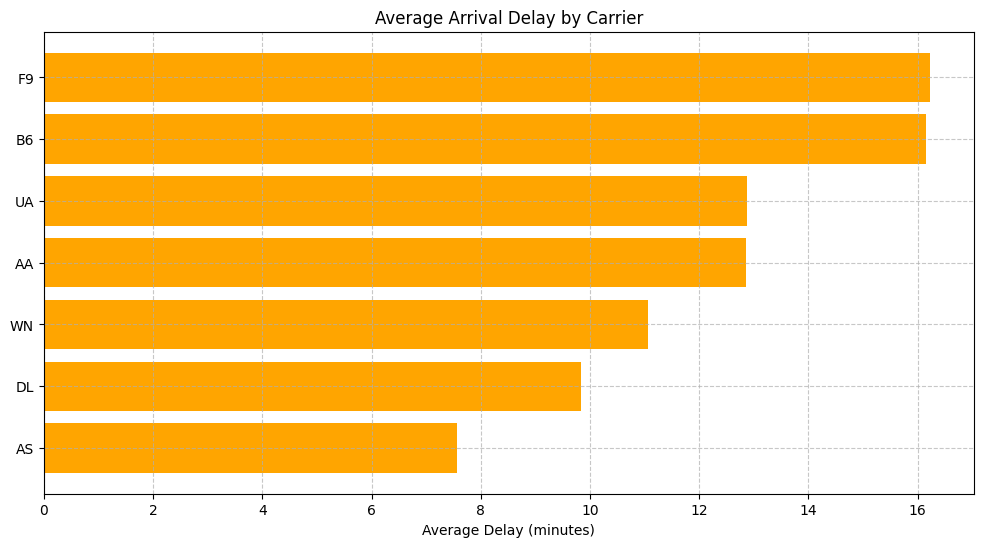

In [ ]:
# Group by carrier and calculate average delay
avg_delay_by_carrier = df.groupby('carrier')['avg_delay'].mean().sort_values(ascending=False).reset_index()

# Visualize
plt.figure(figsize=(12, 6))
plt.barh(avg_delay_by_carrier['carrier'], avg_delay_by_carrier['avg_delay'], color='orange')
plt.xlabel('Average Delay (minutes)')
plt.title('Average Arrival Delay by Carrier')
plt.gca().invert_yaxis()  # Highest delay at the top
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()


Contribution to Delay by Type:


,delay_type,percent_contribution
0,late_aircraft_delay,37.639829
1,carrier_delay,32.507413
2,nas_delay,25.344560
3,weather_delay,4.360737
4,security_delay,0.147461


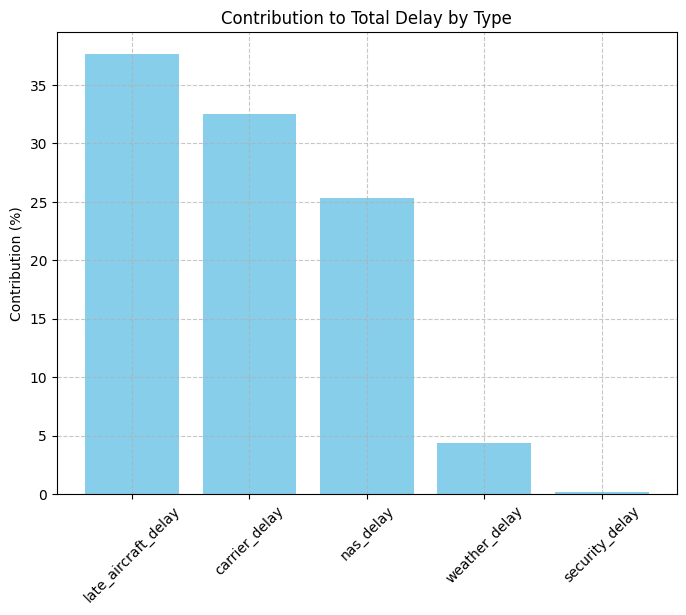

In [ ]:
# Analyze contribution to delay by type
total_delay = df[['carrier_delay', 'weather_delay', 'nas_delay', 'security_delay', 'late_aircraft_delay']].sum()
total_delay_percent = (total_delay / total_delay.sum() * 100).sort_values(ascending=False).reset_index()
total_delay_percent.columns = ['delay_type', 'percent_contribution']

# Standard import
from IPython.display import display

# Display contribution to delay by type
print("Contribution to Delay by Type:")
display(total_delay_percent)

# 🎨 Plot contribution
plt.figure(figsize=(8, 6))
plt.bar(total_delay_percent['delay_type'], total_delay_percent['percent_contribution'], color='skyblue')
plt.ylabel('Contribution (%)')
plt.title('Contribution to Total Delay by Type')
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

From this results,

- Excluded irrelevant columns such as `year`, `month`, and the target (`arr_del15`) from the feature matrix.
- Focused on delay-related features based on their contributions:
  - `Late Aircraft Delay`, `Carrier Delay`, and `NAS Delay` together accounted for ~95% of total delay time.
- Dropped `security_ct` and `security_delay` features due to their negligible contribution (<1%).


## 3. Defining the Prediction Targets

We set up two supervised learning tasks:

### 3.1. Regression Task (Predict average delay time)

- **Goal**: Predict `avg_delay` for each airport-carrier pair.
- **Target**: Continuous variable — `avg_delay` in minutes.

### 3.2. Classification Task (Categorize delay risk level)

- **Goal**: Predict discrete `delay_risk_class` ("high", "medium", "low").

The classification logic is based on the following conditions:

| **Risk Category** | **Condition** |
|-------------------|---------------|
| High              | $$ \text{avg_delay} > 30 \text{ minutes} $$ |
| Medium            | $$ 15 < \text{avg_delay} \leq 30 \text{ minutes} $$ |
| Low               | $$ \text{avg_delay} \leq 15 \text{ minutes} $$ |

This allows us to build separate models for continuous and categorical delay predictions.

---

In [ ]:
def classify_delay_risk(avg_delay):
    if avg_delay > 30:
        return 'high'
    elif avg_delay > 15:
        return 'medium'
    else:
        return 'low'

df['delay_risk_class'] = df['avg_delay'].apply(classify_delay_risk)

In [ ]:
df.head()

,Unnamed: 0,year,month,carrier,carrier_name,airport,airport_name,arr_flights,arr_del15,carrier_ct,...,arr_diverted,arr_delay,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay,avg_delay,cancel_rate,delay_risk_class
0,96,2023,8,AA,American Airlines Inc.,ATL,"Atlanta, GA: Hartsfield-Jackson Atlanta Intern...",759.0,225.0,67.14,...,5.0,20112.0,5665.0,950.0,2152.0,11.0,11334.0,26.498024,0.021080,medium
1,116,2023,8,AA,American Airlines Inc.,CLT,"Charlotte, NC: Charlotte Douglas International",10497.0,2500.0,636.40,...,43.0,294629.0,110971.0,14250.0,29468.0,678.0,139262.0,28.067924,0.021911,medium
2,122,2023,8,AA,American Airlines Inc.,DEN,"Denver, CO: Denver International",739.0,237.0,77.39,...,1.0,21177.0,6971.0,776.0,2876.0,29.0,10525.0,28.656292,0.012179,medium
3,123,2023,8,AA,American Airlines Inc.,DFW,"Dallas/Fort Worth, TX: Dallas/Fort Worth Inter...",14953.0,3212.0,898.24,...,45.0,376057.0,141614.0,7619.0,20738.0,537.0,205549.0,25.149268,0.010098,medium
4,131,2023,8,AA,American Airlines Inc.,EWR,"Newark, NJ: Newark Liberty International",671.0,195.0,62.51,...,2.0,13847.0,4866.0,1221.0,2079.0,31.0,5650.0,20.636364,0.014903,medium




# 4. **Modeling**


##Initial Models

We first try **Random Forest (Tuned)**:
  - Interpretation: Random Forest generalized reasonably well for typical delays but slightly underpredicted rare large delays.

We use RandomizedSearch CV tune hyperparameters for both our Random Forest and XGBoosting models.

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import randint

# Columns to drop (IDs + target arr_del15)
columns_to_drop = ['year', 'month', 'arr_del15']
df_features = df.drop(columns=columns_to_drop)

# Numerical features to keep (meaningful ones only)
numerical_columns = [
    'arr_flights', 'carrier_ct', 'weather_ct', 'nas_ct', 'late_aircraft_ct',
    'arr_cancelled', 'arr_diverted', 'arr_delay',
    'carrier_delay', 'weather_delay', 'nas_delay', 'late_aircraft_delay'
]

# Prepare feature matrix X and target vector y
X = df_features[numerical_columns].fillna(df[numerical_columns].median())
y = df['avg_delay']

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define search space
rf_param_dist = {
    'n_estimators': randint(100, 500),
    'max_depth': randint(5, 20),
    'min_samples_leaf': randint(1, 10),
    'min_samples_split': randint(2, 15),
    'max_features': ['sqrt', 'log2']
}

# Setup RandomizedSearch
rf_search = RandomizedSearchCV(
    RandomForestRegressor(random_state=42),
    param_distributions=rf_param_dist,
    n_iter=30,  # Try 30 random combinations
    scoring='r2',
    cv=5,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# Run search
rf_search.fit(X_train, y_train)

# Best parameters
print("Best Random Forest Parameters:", rf_search.best_params_)
print("Best R²:", rf_search.best_score_)

NameError: name 'df' is not defined

📈 Linear Regression Results:
 - R²: 0.2076
 - MSE: 47.55

🌳 Random Forest Results:
 - R²: 0.9195
 - MSE: 4.83


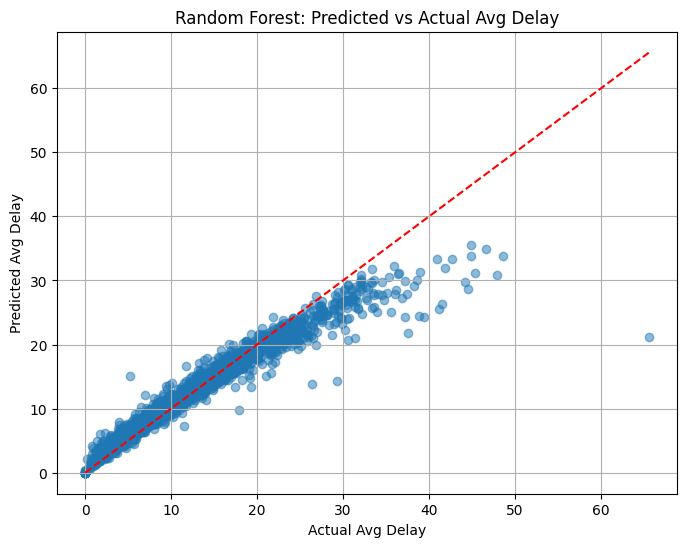

In [ ]:
# Reimport libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt

# Columns to drop (IDs + target arr_del15)
columns_to_drop = ['year', 'month', 'arr_del15']
df_features = df.drop(columns=columns_to_drop)

# Numerical features to keep (meaningful ones only)
numerical_columns = [
    'arr_flights', 'carrier_ct', 'weather_ct', 'nas_ct', 'late_aircraft_ct',
    'arr_cancelled', 'arr_diverted', 'arr_delay',
    'carrier_delay', 'weather_delay', 'nas_delay', 'late_aircraft_delay'
]

# Prepare feature matrix X and target vector y
X = df_features[numerical_columns].fillna(df[numerical_columns].median())
y = df['avg_delay']

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 1. Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)

# 2. Random Forest (Tuned / Regularized)
rf_model = RandomForestRegressor(
    random_state=42,
    n_estimators=149,
    max_depth=19,
    min_samples_leaf=1,
    min_samples_split=5,
    max_features='sqrt'
)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

# Evaluation

print("📈 Linear Regression Results:")
print(f" - R²: {r2_score(y_test, y_pred_lr):.4f}")
print(f" - MSE: {mean_squared_error(y_test, y_pred_lr):.2f}")

print("\n🌳 Random Forest Results:")
print(f" - R²: {r2_score(y_test, y_pred_rf):.4f}")
print(f" - MSE: {mean_squared_error(y_test, y_pred_rf):.2f}")

# Plot Predicted vs Actual for Random Forest
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred_rf, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r')
plt.xlabel('Actual Avg Delay')
plt.ylabel('Predicted Avg Delay')
plt.title('Random Forest: Predicted vs Actual Avg Delay')
plt.grid(True)
plt.show()

### Initial results

- **Linear Regression**:
  - R²: ~0.20
  - MSE: ~47.56
  - Interpretation: Very basic baseline. Struggled to model complex non-linear relationships.

- **Random Forest (Tuned)**:
  - R²: ~0.9195
  - MSE: ~4.83
  - Interpretation: Random Forest generalized reasonably well for typical delays but slightly underpredicted rare large delays.

---

## Model Improvement with XGBoost

- To better capture complex patterns and rare large delays, we applied **Gradient Boosted Trees** using **XGBoost**.
- Additionally, we applied a **log-transform** (`log1p`) to the target `avg_delay` to:
  - Compress extreme large delay values
  - Stabilize model training
  - Improve prediction of rare events

### XGBoost Model Details
- Parameters:
  - `n_estimators=300`
  - `learning_rate=0.05`
  - `max_depth=6`
  - `subsample=0.8`
  - `colsample_bytree=0.8`
- Undo log-transform during final prediction step (`expm1`).


We use RandomizedSearch CV to tune parameters for XGBoost.

In [ ]:
from xgboost import XGBRegressor

# Try log-transforming y to reduce effect of huge outliers
y_log = np.log1p(y)  # log(1 + y) is safer (for 0s)

# Train/Test Split
X_train, X_test, y_train_log, y_test_log = train_test_split(X, y_log, test_size=0.2, random_state=42)


# Define search space
xgb_param_dist = {
    'n_estimators': randint(100, 400),
    'learning_rate': [0.01, 0.03, 0.05, 0.1, 0.2],
    'max_depth': randint(3, 10),
    'subsample': [0.6, 0.7, 0.8, 0.9],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9]
}

# Setup RandomizedSearch
xgb_search = RandomizedSearchCV(
    XGBRegressor(random_state=42),
    param_distributions=xgb_param_dist,
    n_iter=30,
    scoring='r2',
    cv=5,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# Run search
xgb_search.fit(X_train, y_train_log)  # Notice: use y_train_log if you are log-transforming!

# Best parameters
print("Best XGBoost Parameters:", xgb_search.best_params_)
print("Best R²:", xgb_search.best_score_)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best XGBoost Parameters: {'colsample_bytree': 0.9, 'learning_rate': 0.03, 'max_depth': 6, 'n_estimators': 376, 'subsample': 0.6}
Best R²: 0.9942810416076648


🌟 XGBoost Results:
 - Test R²: 0.9832
 - Test MSE: 1.01


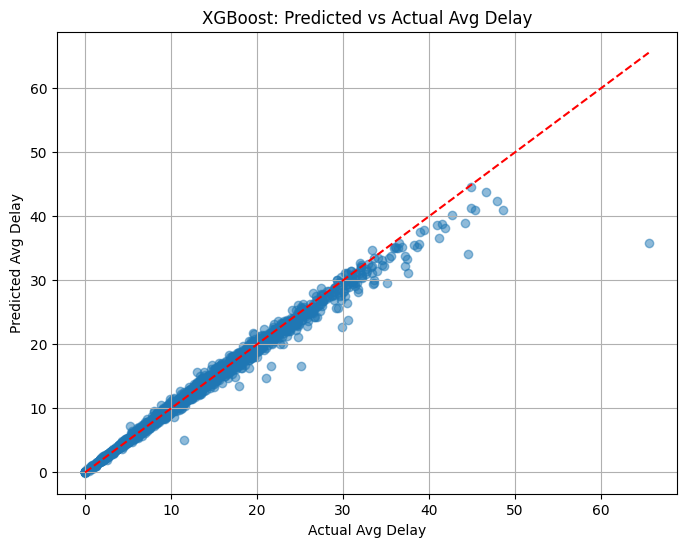

In [ ]:
from xgboost import XGBRegressor


# Try log-transforming y to reduce effect of huge outliers
y_log = np.log1p(y)  # log(1 + y) is safer (for 0s)

# Train/Test Split
X_train, X_test, y_train_log, y_test_log = train_test_split(X, y_log, test_size=0.2, random_state=42)

# Train XGBoost Regressor
xgb_model = XGBRegressor(
    n_estimators=376,
    learning_rate=0.03,
    max_depth=6,
    subsample=0.6,
    colsample_bytree=0.9,
    random_state=42
)

xgb_model.fit(X_train, y_train_log)

# Predict and Undo Log Transform
y_pred_log = xgb_model.predict(X_test)
y_pred = np.expm1(y_pred_log)  # Reverse log1p
y_test_true = np.expm1(y_test_log)

# Evaluation
print("🌟 XGBoost Results:")
print(f" - Test R²: {r2_score(y_test_true, y_pred):.4f}")
print(f" - Test MSE: {mean_squared_error(y_test_true, y_pred):.2f}")

# 🛠️ Step 6: Plot Actual vs Predicted
plt.figure(figsize=(8,6))
plt.scatter(y_test_true, y_pred, alpha=0.5)
plt.plot([y_test_true.min(), y_test_true.max()], [y_test_true.min(), y_test_true.max()], '--r')
plt.xlabel('Actual Avg Delay')
plt.ylabel('Predicted Avg Delay')
plt.title('XGBoost: Predicted vs Actual Avg Delay')
plt.grid(True)
plt.show()


### XGBoost Results
- R²: 0.9832
- MSE: 1.01
- Visual inspection of the Predicted vs Actual plot showed tighter clustering around the ideal 1:1 line compared to previous models. Accuracy is amazing!

---



## 5. Final Observations

| Model             | Test R² | Test MSE | Notes |
|-------------------|---------|----------|-------|
| Linear Regression | ~0.20   | ~47.55   | Weak baseline, no complex patterns captured |
| Random Forest     | ~0.92   | ~4.83      | Good for common delays but struggles with rare events |
| XGBoost (log-transformed target) | ~0.98 | ~1.01 | Best tradeoff between bias and variance |

**Final selected model**: **XGBoost Regressor** with log-transformed target.

---

## 6. Next Steps
- Solve an optimization problem to build an application that recommends optimal flights based on predicted delays.

---


## Preprocessing data for optimization

In [ ]:
# add predicted delay column into the dataset, predict for 20

# Predict on full data (X from original df)
y_pred_log_full = xgb_model.predict(X)
df['predicted_delay'] = np.expm1(y_pred_log_full)  # undo log1p

df

,Unnamed: 0,year,month,carrier,carrier_name,airport,airport_name,arr_flights,arr_del15,carrier_ct,...,arr_delay,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay,avg_delay,cancel_rate,delay_risk_class,predicted_delay
0,96,2023,8,AA,American Airlines Inc.,ATL,"Atlanta, GA: Hartsfield-Jackson Atlanta Intern...",759.0,225.0,67.14,...,20112.0,5665.0,950.0,2152.0,11.0,11334.0,26.498024,0.021080,medium,28.062693
1,116,2023,8,AA,American Airlines Inc.,CLT,"Charlotte, NC: Charlotte Douglas International",10497.0,2500.0,636.40,...,294629.0,110971.0,14250.0,29468.0,678.0,139262.0,28.067924,0.021911,medium,26.352877
2,122,2023,8,AA,American Airlines Inc.,DEN,"Denver, CO: Denver International",739.0,237.0,77.39,...,21177.0,6971.0,776.0,2876.0,29.0,10525.0,28.656292,0.012179,medium,29.969053
3,123,2023,8,AA,American Airlines Inc.,DFW,"Dallas/Fort Worth, TX: Dallas/Fort Worth Inter...",14953.0,3212.0,898.24,...,376057.0,141614.0,7619.0,20738.0,537.0,205549.0,25.149268,0.010098,medium,16.586527
4,131,2023,8,AA,American Airlines Inc.,EWR,"Newark, NJ: Newark Liberty International",671.0,195.0,62.51,...,13847.0,4866.0,1221.0,2079.0,31.0,5650.0,20.636364,0.014903,medium,20.224268
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12737,171556,2013,8,WN,Southwest Airlines Co.,LGA,"New York, NY: LaGuardia",527.0,186.0,60.08,...,11258.0,2894.0,1148.0,4427.0,0.0,2789.0,21.362429,0.003795,medium,20.841541
12738,171565,2013,8,WN,Southwest Airlines Co.,CLT,"Charlotte, NC: Charlotte Douglas International",183.0,51.0,24.13,...,2261.0,969.0,178.0,209.0,0.0,905.0,12.355191,0.000000,low,11.802032
12739,171569,2013,8,WN,Southwest Airlines Co.,SLC,"Salt Lake City, UT: Salt Lake City International",976.0,341.0,110.77,...,15033.0,3957.0,271.0,1149.0,16.0,9640.0,15.402664,0.001025,medium,14.787582
12740,171572,2013,8,WN,Southwest Airlines Co.,STL,"St. Louis, MO: St Louis Lambert International",2648.0,628.0,203.47,...,27605.0,8038.0,1016.0,2690.0,202.0,15659.0,10.424849,0.001511,low,10.494865


In [ ]:
# Get all unique (carrier, airport) pairs in the dataset
carrier_airport_combos = df[['carrier', 'airport']].drop_duplicates()
carrier_airport_combos

,carrier,airport
0,AA,ATL
1,AA,CLT
2,AA,DEN
3,AA,DFW
4,AA,EWR
...,...,...
2492,F9,LAX
2500,F9,SJC
4308,AA,OAK
4340,B6,OAK


In [ ]:
# Group by carrier and origin airport
avg_pred_delays = df.groupby(['carrier', 'airport'])['predicted_delay'].mean().reset_index()

# Rename for clarity
avg_pred_delays.rename(columns={'origin': 'airport', 'predicted_delay': 'avg_predicted_delay'}, inplace=True)

# Preview
avg_pred_delays

,carrier,airport,avg_predicted_delay
0,AA,ATL,12.921324
1,AA,CLT,10.313781
2,AA,DEN,12.605865
3,AA,DFW,13.548542
4,AA,EWR,17.178791
...,...,...,...
107,WN,SEA,10.470112
108,WN,SFO,15.787549
109,WN,SJC,8.285672
110,WN,SLC,10.557791


In [ ]:
avg_pred_delays.to_csv('avg_predicted_delay_by_carrier_airport.csv', index=False)